<div align = "center"><img src = "https://upload.wikimedia.org/wikipedia/en/thumb/3/3b/Stony_Brook_U_logo_vertical.svg/1024px-Stony_Brook_U_logo_vertical.svg.png" width ="300"></div>

# <div align="center"> **AMS 512 Notebook Project: Mathematica to Python** </div>

## <div align="center"> **Extreme Events** </div>

### <div align = "center"> **Authors:** *Ainasse, El Mehdi, de Oliveira Gomes, Marlon, and Lize, Matheus Loss* </div>

## **Disclaimer**

All present contents are mainly excerpts from the original notebook by Prof. Robert J. Frey. In particular, textual contents are directly quoted and/or copy-pasted while the coding components have been re-adapted from Mathematica to Python.

# **Initial set-up**

In [94]:
import pandas as pd
import numpy as np
import math
import os
import scipy.stats as stats
import sys
import random
import matplotlib.pyplot as plt
import seaborn as sns

# **A look at real data**

### **Downloading and processing the data**

The file 'mxSP500Index.csv' contains monthly index data for the S & P 500 Total Return Index from December 1899 to December 2015. The term 'total return' in this instance includes the reinvestment of dividends back into the index so that ir properly represents the total wealth from investing in the infex. Although this index did not exist over this period, the file a reconstruction of it by Global Financial Data. 

In [96]:
data = pd.read_csv("mxSP500Index.csv",
                   index_col = 'date')
data.index = pd.to_datetime(data.index, format = '%Y-%m-%d')

In [97]:
data

,return
date,
1899-12-31,0.099705
1900-01-31,0.101342
1900-02-28,0.103484
1900-03-31,0.104631
1900-04-30,0.106294
...,...
2015-08-31,3660.750000
2015-09-30,3570.170000
2015-10-30,3871.330000


Plot time series data

Log plot of time series data.

<AxesSubplot:xlabel='date'>

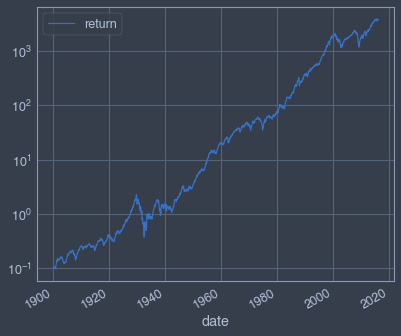

In [98]:
data.plot(logy = True)

In [ ]:
We can compute the log returns 

In [99]:
def get_log_return(df):
    log_returns = pd.Series(np.log(df['return']).diff(),name='log returns')
    return pd.concat([df,log_returns], axis=1)

In [100]:
mxSP500LogReturn = get_log_return(data).iloc[1:]
mxSP500LogReturn

,return,log returns
date,,
1900-01-31,0.101342,0.016280
1900-02-28,0.103484,0.020918
1900-03-31,0.104631,0.011023
1900-04-30,0.106294,0.015769
1900-05-31,0.101591,-0.045255
...,...,...
2015-08-31,3660.750000,-0.062231
2015-09-30,3570.170000,-0.025055
2015-10-30,3871.330000,0.080985


<AxesSubplot:xlabel='date'>

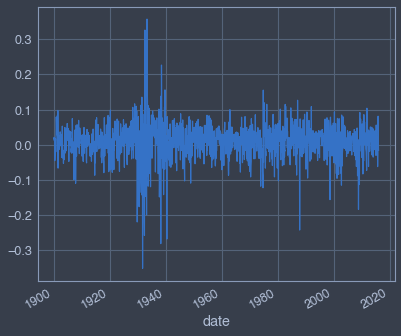

In [101]:
mxSP500LogReturn['log returns'].plot()

In [10]:
#mxSP500LogReturn['log returns'].to_csv('mxSP500LogReturn.csv')

# **Characterizing the return distribution**

### **Fitting candidate distributions**

The historgram has an option for a binning strategy, such as 'auto', 'sturges', 'fd', 'doane', 'scott', 'rice' or 'sqrt'. 
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html 

```
bins = 'fd' stands for Freedman-Diaconis rule to compute bin widths. Below is a 
description of the FD rule. 

def FD_histogram(df):
    
    q1 = df["log returns"].quantile(.75)
    q2 = df["log returns"].quantile(.25)
    n = len(df["log returns"])
    bin_width = 2*(q1 - q2)*(n**(-1/3))
    #num_of_bins = math.floor((df["log returns"].max()-df["log returns"].min())/bin_width)
    num_of_bins = math.ceil((df["log returns"].max()-df["log returns"].min())/bin_width)
   
    return df["log returns"].hist(bins=num_of_bins,density =True)
```


In [102]:
# X -axis from the histogram:
_, x_bins = np.histogram(mxSP500LogReturn['log returns'], bins='fd', density = True)

Statistical functions (scipy.stats) documentation:  
https://docs.scipy.org/doc/scipy/reference/stats.html

First we chose a distribution ( normal , student-t or non-central student t) to fit the data, using: 

$$stats.*distribution*.fit(data).$$
Ex: Normal distribution ->   stats.norm.fit (data)

Then we generate the pdf to plot the model vs the histogram. 
We use 

$$ stats.*distribution*.pdf(x, *Fit-Parameters* ), $$

where x is x-axis from the histogram plot (bins) and Fit-Parameters were computed in the previews step ( stats.*distribution*.fit).


In [103]:
# The last 4 objects are: mean , variance , skew, kurtosis
observedStats = np.array(stats.describe(mxSP500LogReturn['log returns'])[2:])
observedStats

array([ 7.58186887e-03,  2.58937615e-03, -4.78151658e-01,  8.20524350e+00])

In [ ]:
# Normal Distribution: 

In [104]:
normParameter = stats.norm.fit(mxSP500LogReturn['log returns'])
normParameter

(0.0075818688726212655, 0.05086763182310351)

In [34]:
normPDF = stats.norm.pdf(x_bins,*normParameter)

In [105]:
normStats = np.array(stats.norm.stats(*normParameter,moments='mvsk'))
normStats

array([0.00758187, 0.00258752, 0.        , 0.        ])

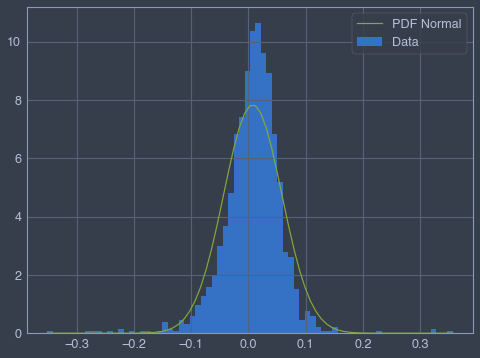

In [106]:
plt.figure(num=None, figsize=(8, 6))
plt.hist(mxSP500LogReturn['log returns'],bins='fd',density=True,label='Data')
plt.plot(x_bins,normPDF,label='PDF Normal')
plt.legend()

In [107]:
# Student t distribution 
sTParameter= stats.t.fit(mxSP500LogReturn['log returns'])
sTParameter

(3.832627435543939, 0.010398545919483748, 0.034762484815485176)

In [108]:
sTPDF = stats.t.pdf(x_bins,*sTParameter)

In [109]:
# Statistical information: 
# First 4 moments - mean(m) , variance (v), skew(s), kurtosis(k) -> 'mvsk'
stStats = np.array(stats.t.stats(*sTParameter,moments='mvsk'))
stStats

array([0.01039855, 0.00252723, 0.        ,        inf])

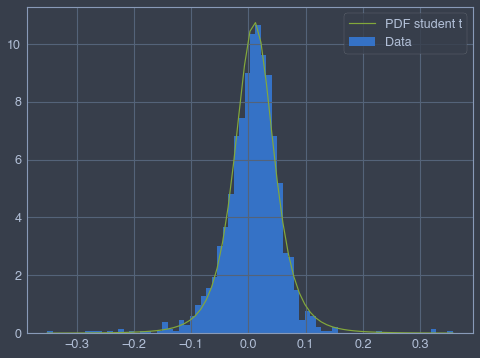

In [110]:
# PLOT: 
plt.figure(num=None, figsize=(8, 6))
plt.hist(mxSP500LogReturn['log returns'],bins='fd',density=True,label='Data')
plt.plot(x_bins,sTPDF,label='PDF student t')
plt.legend()

In [111]:
# Non central Student-t distribution 
nctParameter= stats.nct.fit(mxSP500LogReturn['log returns'])
nctParameter

/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(3.9001685848114462,
 -0.5770249797710596,
 0.03210325628817566,
 0.03413539247386711)

In [45]:
ncsTPDF = stats.nct.pdf(x_bins,*nctParameter)

In [112]:
# Statistical information: 
# First 4 moments - mean(m) , variance (v), skew(s), kurtosis(k) -> 'mvsk'
nctStats = np.array( stats.nct.stats(*nctParameter,moments='mvsk'))
nctStats

array([ 0.00724297,  0.00256996, -1.62171206,         nan])

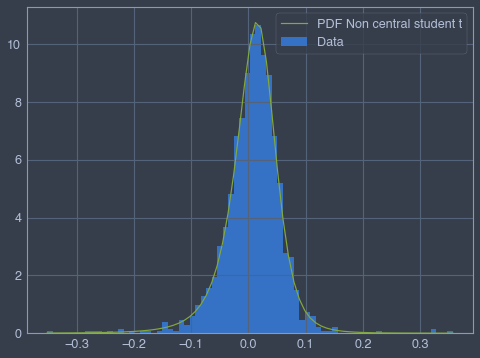

In [113]:
plt.figure(num=None, figsize=(8, 6))
plt.hist(mxSP500LogReturn['log returns'],bins='fd',density=True,label='Data')
plt.plot(x_bins,ncsTPDF,label='PDF Non central student t')
plt.legend()

In [ ]:
# Comparing all Models:

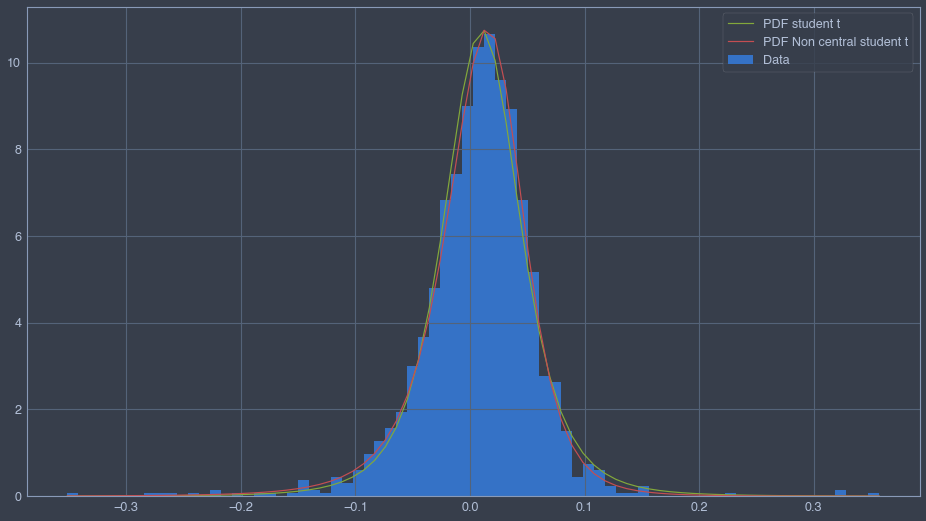

In [114]:
plt.figure(num=None, figsize=(16, 9))
plt.hist(mxSP500LogReturn['log returns'],bins='fd',density=True,label='Data')
#plt.plot(x_bins,NormPDF,label='PDF Norm')
plt.plot(x_bins,sTPDF,label='PDF student t')
plt.plot(x_bins,ncsTPDF,label='PDF Non central student t')
plt.legend()

In [115]:
# Table of summary statistics: 
pd.DataFrame([observedStats,normStats,stStats,nctStats],
             columns=['mean', 'variance','skew','kurtosis'],
             index=['Observed','Normal','Student t','Non-central st'])

,mean,variance,skew,kurtosis
Observed,0.007582,0.002589,-0.478152,8.205244
Normal,0.007582,0.002588,0.000000,0.000000
Student t,0.010399,0.002527,0.000000,inf
Non-central st,0.007243,0.002570,-1.621712,NaN


In [ ]:
##################################################################################################################################################################### QUANTILE PLOTS
####################################################################################################################################################################

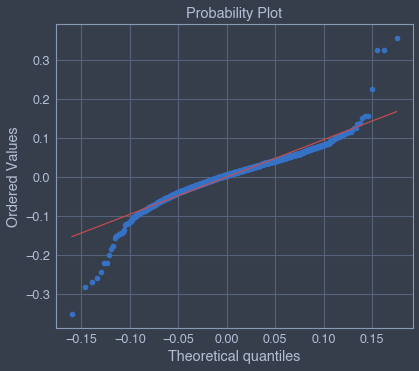

In [151]:
fig, ax = plt.subplots()
res0 = stats.probplot(mxSP500LogReturn['log returns'],
                     dist=stats.norm(*normParameter),
                     plot= ax)
plt.show()

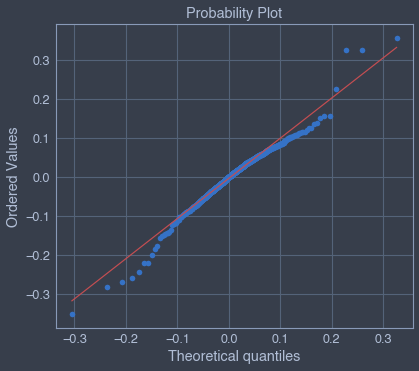

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(mxSP500LogReturn['log returns'], 
                     dist = stats.t(*sTParameter),
                     plot = ax)
plt.show()

Take a look on more sophisticated plots [here](https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html) .


# **Power Law Models of Extreme Events**

In [121]:
samplesize = 100000

In [122]:
normSample = stats.norm.rvs(size =samplesize,random_state =1)

In [123]:
cauchySample = stats.cauchy.rvs(size = samplesize,random_state =1)

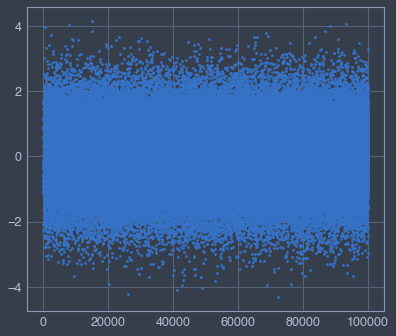

In [128]:
plt.plot(normSample,'.')

<StemContainer object of 3 artists>

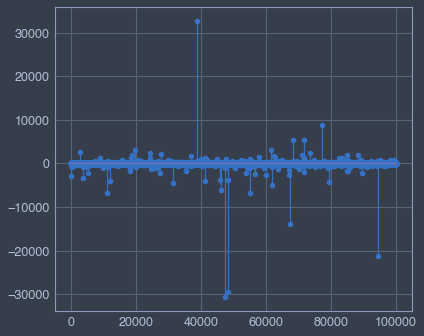

In [126]:
plt.stem(cauchySample)

In [129]:
len(normSample[abs(normSample) > 3 ]) /len(normSample)

0.00288

In [130]:
len(cauchySample[abs(cauchySample) > 3 ])/len(cauchySample)

0.20662

# Value at Risk and Expected Shortfall

### General definition

<p>The <a href="https://en.wikipedia.org/wiki/Value_at_risk" target = "_blank">Value-at-Risk</a> or VaR is the minimum loss expected over a given time period at a given confidence level. Note there are three components to VaR:
<ul>
    <li> the loss tolerance;</li>
    <li> the time period $\tau$;</li>
    <li> the confidence level $\chi$.</li>
</ul>
If $F_{\tau}$ is the cumulative distribution functiono of returns over a period of length $\tau$, then the $\mathrm{VaR}_{\tau,\chi}$ satisfies he following relationship:
$$ F_{\tau}(\mathrm{VaR}_{\tau,\chi}) = 1 - \chi,$$
in other words, 
$$\mathrm{VaR}_{\tau,\chi} = F^{-1}_{\tau}(1-\chi).$$
</p>

### Example - S&P500

<p> Below we compute the VaR for the monthly returns of the S$\&$P 500 at a $99.9\%$ confidence level.</p>

In [131]:
nConfLimit = 0.999

<p>Given a distribution object, such as stats.norm or stats.t, the method ppf() computes the inverse cumulative distribution function. Its syntax is: ppf(value, distribution parameters).</p>

In [132]:
nVaRN = stats.norm.ppf(1-nConfLimit, *normParameter)
nVaRN

-0.14961093032538314

<p>The <a href="https://en.wikipedia.org/wiki/Expected_shortfall" target="_blank">expected shortfall</a>, usually called the conditional VaR or CVaR, is the expected value of a loss that exceeds the VaR. Note that we have to include the normalization $1/(1-\chi)$ to account for the fact that we are compution a conditional expectation. 
$$\mathrm{CVaR}_{\tau,\chi} = \mathrm{E}\left[r| r\leq \mathrm{VaR}_{\tau,\chi} \right] = \frac{1}{1-F_{\tau}(\mathrm{VaR}_{\tau,\chi})} \int_{\infty}^{\mathrm{VaR}_{\tau,\chi}} rf_{\tau}(r)dr = \frac{1}{1-\chi}\int_{\infty}^{\mathrm{VaR}_{\tau,\chi}} rf_{\tau}(r)dr$$
</p>

<p> The scipy stats library contains methods to compute this associated to common probability distributions. These are called expect(), and typically follow the syntax below: </p>

 ```
    stats.dist.expect(func = None, 
                      args = {},
                      parameters,
                      lb = None, # lower bound
                      up = None, # upper bound
                      conditional = False,
                      **kwargs)
```
<p> This computes the weighted integral of function, 
    $$E(f(x)) = \int_{lb}^{up} \mathrm{func}(x)*\mathrm{dist.pdf}(x) dx$$
    with weights assined according to the pdf of the distribution in question, where
    <ul>
        <li>"func = None" by default uses the identity $f(x) = x$; </li>
        <li> args are shape parameters of the distribution; </li> 
        <li> lower bound (lb) and upper bound (ub) are set to the support of the distribution;</li>
        <li> if "conditional = True" the integral is normalized by the conditional probability of the integration interval.</li>
    </ul>
</p>    

In [185]:
nCVaRN = stats.norm.expect(loc = normParameter[0],
                  scale = normParameter[1], 
                  lb = -np.Inf, ub = nVaRN,
                 conditional = True)
nCVaRN

-0.163694029482695

<p> Below we repeat these steps for the Student t distribution and the noncentral Student t distribution.</p>

In [152]:
nVaRT = stats.t.ppf(1-nConfLimit, *sTParameter)
nVaRT

-0.25031898046799955

In [175]:
nCVaRT = stats.t.expect( args = [sTParameter[0]],
                        loc = sTParameter[1],
                        scale = sTParameter[2],
                       lb = -np.Inf,
                       ub = nVaRT,
                       conditional = True)
nCVaRT

-0.3464230586547145

In [176]:
nVaRST = stats.nct.ppf(1-nConfLimit, *nctParameter)
nVaRST

-0.30646477223087815

In [184]:
nCVaRST = stats.nct.expect( args = (nctParameter[0:2]),
                        loc = nctParameter[2],
                        scale = nctParameter[3],
                       lb = -np.Inf,
                       ub = nVaRST,
                       conditional = True)
nCVaRST

-0.4270998549998463

<p> At a confidence level of 99.9%, the values-at-risk and expected shortfalls are:</p>

In [189]:
vxVaR = np.array([nVaRN, nVaRT, nVaRST])
vxCVaR = np.array([nCVaRN, nCVaRT, nCVaRST])
pd.DataFrame({'VaR':vxVaR, 'CVaR': vxCVaR}, 
             index = ['Normal', 'Student t', 'Skew Student t'])

,VaR,CVaR
Normal,-0.149611,-0.163694
Student t,-0.250319,-0.346423
Skew Student t,-0.306465,-0.427100
